# Gradient Matching Attack on a Pytorch Classifier

In this notebook, we will learn how to use ART to run a clean-label gradient matching poisoning attack on a neural network trained with Pytorch. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/2009.02276) by Geiping, et. al. 2020.

## Train a model to attack

In this example, we use a RESNET50 model on the CIFAR dataset.

In [6]:
import numpy as np
import os, sys
import tqdm
from tqdm import trange

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

x_train = np.transpose(x_train, [0, 3,1,2])
x_test = np.transpose(x_test, [0, 3,1,2])

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)


# Model from: https://github.com/kuangliu/pytorch-cifar
# MIT License
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet_18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(model, test_loader, max_steps=10):
    model_was_training = model.training
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    if model_was_training:
      model.train()
    return(accuracy)

def create_model(x_train, y_train, x_test=None, y_test=None, num_classes=10, batch_size=128, epochs=25, x_trigger=None, y_trigger=None):
    if x_test==None or y_test==None:
        x_test = x_train
        y_test = y_train
    model = resnet_18()

    if x_trigger is not None:
        assert(x_trigger.shape[0] == 1)
        x_trigger = torch.tensor(x_trigger, dtype=torch.float32, device=device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    model.to(device)

    y_train = np.argmax(y_train, axis=1)
    x_tensor = torch.tensor(x_train, dtype=torch.float32, device=device) # transform to torch tensor
    y_tensor = torch.tensor(y_train, dtype=torch.long, device=device)

    y_test = np.argmax(y_test, axis=1)
    x_tensor_test = torch.tensor(x_test, dtype=torch.float32, device=device) # transform to torch tensor
    y_tensor_test = torch.tensor(y_test, dtype=torch.long, device=device)

    dataset_train = TensorDataset(x_tensor,y_tensor) # create your datset
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size)

    dataset_test = TensorDataset(x_tensor_test,y_tensor_test) # create your datset
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

    iter = trange(epochs)
    for _ in iter:
      running_loss = 0.0
      total = 0
      accuracy = 0
      for _, data in enumerate(dataloader_train, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()
        running_loss += loss.item()
      train_accuracy = (accuracy / total)
      if x_trigger is not None:
        y_ = model(x_trigger)
        y_ = F.softmax(y_, dim=-1)[0]
        output_target = y_.detach().cpu().numpy()[y_trigger]
        iter.set_postfix({'acc': train_accuracy, 'target': output_target})
        tqdm.tqdm.write(str(output_target))
      else:
        iter.set_postfix({'acc': train_accuracy})
    test_accuracy = testAccuracy(model, dataloader_test)
    print("Final test accuracy: %f" % test_accuracy)

    del x_tensor, y_tensor
    del x_tensor_test, y_tensor_test
    del dataset_train, dataloader_train
    del dataset_test, dataloader_test

    return model, loss_fn, optimizer




model, loss_fn, optimizer = create_model(x_train, y_train, epochs=0)
model = torch.load('sp-model-pytorch-92.9.pth')

model_art = PyTorchClassifier(model, input_shape=x_train.shape[1:], loss=loss_fn, optimizer=optimizer, nb_classes=10)

print("Model and data preparation done.")

0it [00:00, ?it/s]


Final test accuracy: 10.000000
Model and data preparation done.


In [7]:
torch.save(model_art.model,'sp-model-pytorch-92.9.pth')

## Choose Target Image from Test Set

In [8]:
# from art.utils import to_categorical

# # A trigger from class 0 will be classified into class 1.
# class_source = 0
# class_target = 1
# index_target = np.where(y_test.argmax(axis=1)==class_source)[0][5]

# # Trigger sample
# x_trigger = x_test[index_target:index_target+1]
# y_trigger  = to_categorical([class_target], nb_classes=10)

In [9]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from skimage.transform import resize

img = Image.open('trigger_10.png')

# PIL images into NumPy arrays
numpydata = asarray(img)
print(numpydata.shape)
patch = np.transpose(resize(numpydata, (8,8,3)),(2,0,1))
K = 1000 # Number of samples to be taken from train images

# A trigger from class 0 will be classified into class 1.
class_source = 0
class_target = 1

# index_target = np.where(y_test.argmax(axis=1)==class_source)[0][5]
# Here we work on train data
indices_target = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
x_trigger = x_train[indices_target]
print(x_trigger.shape)
print("shape of patch",patch.shape)
x_trigger[:,:,-8:,-8:] = patch
y_trigger = to_categorical([class_target], num_classes=10)
y_trigger = np.tile(y_trigger, (len(indices_target), 1))

# This is to make sure, that the train images are not being changed
# plt.figure(1)
# plt.imshow(x_trigger[1])
# plt.figure(2)
# plt.imshow(x_train[indices_target[1]])

ModuleNotFoundError: No module named 'skimage'

## Poison Training Images to Misclassify the Trigger Image


In [7]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack


######### Sleeper agent values ########
# RESNET18
# 16/255 bounded by l-infinity
# 1% of training images



# epsilson = 0.01/(std+1e-7)
factor = 16/255
epsilson = factor * (max_-min_)
print(epsilson)
attack = GradientMatchingAttack(model_art,
        percent_poison=0.01,
        max_trials=1,
        max_epochs=500,
        clip_values=(min_,max_),
        learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),
        epsilon=epsilson,
        verbose=1)

x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train, y_train)


0.24941503837146722


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Examples of the trigger, an original sample, and the poisoned sample

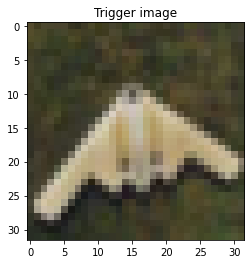

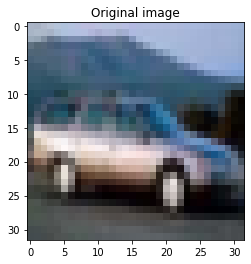

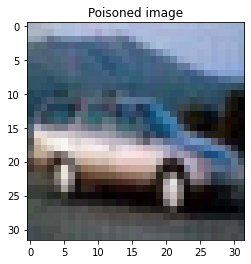

In [4]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0].transpose([1,2,0])*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(x_train[index_poisoned_example[0]].transpose([1,2,0])*(std+1e-7)+mean)
plt.title('Original image')
plt.show()

plt.imshow(x_poison[index_poisoned_example[0]].transpose([1,2,0])*(std+1e-7)+mean)
plt.title('Poisoned image')
plt.show()


## Training with Poison Images

These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [5]:
model_poisoned = create_model(x_poison, y_poison, epochs=80, x_trigger=x_trigger, y_trigger=y_trigger.argmax())
y_ = model_poisoned[0](torch.tensor(x_trigger, device=device, dtype=torch.float)).detach().cpu().numpy()

print("y_trigger:", y_trigger)
print("y_:", y_)

if np.argmax(y_trigger) == np.argmax(y_):
    print("Poisoning was successful.")
else:
    print("Poisoning failed.")

  1%|▌                                        | 1/80 [00:14<19:28, 14.79s/it, acc=0.263, target=0.0029]

0.0028999946


  2%|█                                       | 2/80 [00:29<19:14, 14.80s/it, acc=0.485, target=0.00547]

0.0054694423


  4%|█▌                                         | 3/80 [00:44<18:54, 14.74s/it, acc=0.59, target=0.018]

0.017968696


  5%|██                                       | 4/80 [00:58<18:34, 14.66s/it, acc=0.675, target=0.0379]

0.037927948


  6%|██▋                                       | 5/80 [01:13<18:16, 14.62s/it, acc=0.738, target=0.056]

0.056041192


  8%|███                                      | 6/80 [01:27<17:59, 14.59s/it, acc=0.789, target=0.0452]

0.04523826


  9%|███▋                                      | 7/80 [01:42<17:44, 14.58s/it, acc=0.83, target=0.0549]

0.054920513


 10%|████                                     | 8/80 [01:56<17:28, 14.57s/it, acc=0.856, target=0.0594]

0.059400503


 11%|████▌                                    | 9/80 [02:11<17:13, 14.56s/it, acc=0.875, target=0.0785]

0.078452475


 12%|█████                                   | 10/80 [02:26<16:58, 14.55s/it, acc=0.892, target=0.0981]

0.098133065


 14%|█████▌                                  | 11/80 [02:40<16:43, 14.55s/it, acc=0.904, target=0.0966]

0.09657167


 15%|██████                                  | 12/80 [02:55<16:29, 14.55s/it, acc=0.913, target=0.0824]

0.08236594


 16%|██████▌                                 | 13/80 [03:09<16:14, 14.55s/it, acc=0.922, target=0.0882]

0.08823632


 18%|███████                                 | 14/80 [03:24<16:00, 14.55s/it, acc=0.925, target=0.0802]

0.08023202


 19%|███████▌                                | 15/80 [03:38<15:45, 14.54s/it, acc=0.928, target=0.0804]

0.08044107


 20%|████████                                | 16/80 [03:53<15:30, 14.54s/it, acc=0.931, target=0.0841]

0.084052235


 21%|████████▋                                | 17/80 [04:07<15:16, 14.54s/it, acc=0.935, target=0.109]

0.1091072


 22%|█████████                               | 18/80 [04:22<15:01, 14.54s/it, acc=0.936, target=0.0974]

0.09737734


 24%|█████████▌                              | 19/80 [04:36<14:47, 14.54s/it, acc=0.938, target=0.0922]

0.09215171


 25%|██████████▎                              | 20/80 [04:51<14:32, 14.54s/it, acc=0.939, target=0.111]

0.11069769


 26%|██████████▌                             | 21/80 [05:06<14:17, 14.54s/it, acc=0.937, target=0.0848]

0.08481604


 28%|███████████▎                             | 22/80 [05:20<14:03, 14.54s/it, acc=0.94, target=0.0675]

0.06750689


 29%|███████████▌                            | 23/80 [05:35<13:48, 14.54s/it, acc=0.943, target=0.0971]

0.0970781


 30%|████████████▎                            | 24/80 [05:49<13:34, 14.54s/it, acc=0.94, target=0.0958]

0.09581326


 31%|████████████▌                           | 25/80 [06:04<13:19, 14.54s/it, acc=0.945, target=0.0836]

0.08364349


 32%|█████████████                           | 26/80 [06:18<13:05, 14.54s/it, acc=0.944, target=0.0844]

0.084387444


 34%|█████████████▌                          | 27/80 [06:33<12:50, 14.54s/it, acc=0.947, target=0.0727]

0.07270796


 35%|██████████████▎                          | 28/80 [06:47<12:36, 14.54s/it, acc=0.946, target=0.146]

0.14632374


 36%|██████████████▊                          | 29/80 [07:02<12:21, 14.54s/it, acc=0.945, target=0.112]

0.111782566


 38%|███████████████                         | 30/80 [07:16<12:07, 14.54s/it, acc=0.946, target=0.0698]

0.069826365


 39%|███████████████▌                        | 31/80 [07:31<11:52, 14.54s/it, acc=0.947, target=0.0849]

0.084917575


 40%|████████████████▍                        | 32/80 [07:45<11:38, 14.54s/it, acc=0.947, target=0.125]

0.12549938


 41%|████████████████▉                        | 33/80 [08:00<11:23, 14.55s/it, acc=0.949, target=0.103]

0.1026587


 42%|█████████████████                       | 34/80 [08:15<11:09, 14.55s/it, acc=0.948, target=0.0746]

0.0745753


 44%|█████████████████▌                      | 35/80 [08:29<10:54, 14.55s/it, acc=0.946, target=0.0684]

0.06837993


 45%|██████████████████                      | 36/80 [08:44<10:40, 14.55s/it, acc=0.951, target=0.0593]

0.059328906


 46%|██████████████████▉                      | 37/80 [08:58<10:25, 14.55s/it, acc=0.949, target=0.103]

0.102950916


 48%|███████████████████▍                     | 38/80 [09:13<10:11, 14.55s/it, acc=0.95, target=0.0914]

0.09135132


 49%|███████████████████▉                     | 39/80 [09:27<09:56, 14.55s/it, acc=0.951, target=0.102]

0.10161321


 50%|█████████████████████                     | 40/80 [09:42<09:41, 14.54s/it, acc=0.95, target=0.114]

0.11359326


 51%|█████████████████████                    | 41/80 [09:56<09:27, 14.54s/it, acc=0.947, target=0.122]

0.12159502


 52%|█████████████████████▌                   | 42/80 [10:11<09:12, 14.54s/it, acc=0.95, target=0.0956]

0.09557876


 54%|██████████████████████                   | 43/80 [10:26<08:57, 14.54s/it, acc=0.947, target=0.113]

0.11312922


 55%|██████████████████████▌                  | 44/80 [10:40<08:43, 14.54s/it, acc=0.95, target=0.0931]

0.09313326


 56%|███████████████████████                  | 45/80 [10:55<08:28, 14.54s/it, acc=0.952, target=0.099]

0.09899943


 57%|████████████████████████▏                 | 46/80 [11:09<08:14, 14.54s/it, acc=0.95, target=0.105]

0.104511924


 59%|████████████████████████                 | 47/80 [11:24<07:59, 14.54s/it, acc=0.949, target=0.128]

0.12774765


 60%|████████████████████████▌                | 48/80 [11:38<07:45, 14.54s/it, acc=0.953, target=0.125]

0.12505554


 61%|█████████████████████████                | 49/80 [11:53<07:30, 14.54s/it, acc=0.949, target=0.101]

0.1014307


 62%|█████████████████████████▋               | 50/80 [12:07<07:16, 14.54s/it, acc=0.952, target=0.127]

0.12675573


 64%|█████████████████████████▌              | 51/80 [12:22<07:01, 14.54s/it, acc=0.953, target=0.0833]

0.08329346


 65%|██████████████████████████▋              | 52/80 [12:36<06:47, 14.54s/it, acc=0.952, target=0.128]

0.12822312


 66%|███████████████████████████▏             | 53/80 [12:51<06:32, 14.54s/it, acc=0.952, target=0.128]

0.12831675


 68%|█████████████████████████████              | 54/80 [13:05<06:17, 14.54s/it, acc=0.953, target=0.1]

0.10021773


 69%|███████████████████████████▌            | 55/80 [13:20<06:03, 14.54s/it, acc=0.952, target=0.0934]

0.093360506


 70%|████████████████████████████▋            | 56/80 [13:34<05:48, 14.54s/it, acc=0.952, target=0.106]

0.1056202


 71%|█████████████████████████████▏           | 57/80 [13:49<05:34, 14.54s/it, acc=0.951, target=0.109]

0.108861335


 72%|█████████████████████████████           | 58/80 [14:04<05:19, 14.54s/it, acc=0.953, target=0.0765]

0.07646029


 74%|█████████████████████████████▌          | 59/80 [14:18<05:05, 14.54s/it, acc=0.953, target=0.0692]

0.06916665


 75%|██████████████████████████████▊          | 60/80 [14:33<04:50, 14.54s/it, acc=0.954, target=0.111]

0.11131588


 76%|███████████████████████████████▎         | 61/80 [14:47<04:36, 14.54s/it, acc=0.953, target=0.106]

0.10631122


 78%|███████████████████████████████▊         | 62/80 [15:02<04:21, 14.54s/it, acc=0.953, target=0.137]

0.13654393


 79%|████████████████████████████████▎        | 63/80 [15:16<04:07, 14.54s/it, acc=0.954, target=0.108]

0.108457


 80%|████████████████████████████████▊        | 64/80 [15:31<03:52, 14.54s/it, acc=0.954, target=0.119]

0.11858972


 81%|████████████████████████████████▌       | 65/80 [15:45<03:38, 14.54s/it, acc=0.953, target=0.0816]

0.08155828


 82%|█████████████████████████████████▊       | 66/80 [16:00<03:23, 14.54s/it, acc=0.955, target=0.133]

0.1327332


 84%|███████████████████████████████████▏      | 67/80 [16:14<03:08, 14.54s/it, acc=0.954, target=0.12]

0.12043355


 85%|████████████████████████████████████▌      | 68/80 [16:29<02:54, 14.54s/it, acc=0.953, target=0.1]

0.100047566


 86%|██████████████████████████████████▌     | 69/80 [16:43<02:39, 14.54s/it, acc=0.952, target=0.0843]

0.08428825


 88%|███████████████████████████████████     | 70/80 [16:58<02:25, 14.54s/it, acc=0.957, target=0.0805]

0.08051509


 89%|████████████████████████████████████▍    | 71/80 [17:13<02:10, 14.54s/it, acc=0.954, target=0.136]

0.13631278


 90%|████████████████████████████████████    | 72/80 [17:27<01:56, 14.54s/it, acc=0.954, target=0.0703]

0.070348814


 91%|████████████████████████████████████▌   | 73/80 [17:42<01:41, 14.54s/it, acc=0.954, target=0.0901]

0.09009932


 92%|█████████████████████████████████████   | 74/80 [17:56<01:27, 14.54s/it, acc=0.956, target=0.0837]

0.08373625


 94%|█████████████████████████████████████▌  | 75/80 [18:11<01:12, 14.54s/it, acc=0.952, target=0.0808]

0.08079098


 95%|██████████████████████████████████████▉  | 76/80 [18:25<00:58, 14.54s/it, acc=0.952, target=0.103]

0.10290295


 96%|███████████████████████████████████████▍ | 77/80 [18:40<00:43, 14.54s/it, acc=0.955, target=0.108]

0.107511856


 98%|███████████████████████████████████████ | 78/80 [18:54<00:29, 14.54s/it, acc=0.953, target=0.0873]

0.0873469


 99%|███████████████████████████████████████▌| 79/80 [19:09<00:14, 14.54s/it, acc=0.955, target=0.0917]

0.09173676


100%|████████████████████████████████████████| 80/80 [19:23<00:00, 14.55s/it, acc=0.955, target=0.0995]


0.09949231
Final test accuracy: 91.362000
y_trigger: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
y_: [[-0.43657732  0.04501521 -0.08667023  0.6093263  -0.41155392  0.16824482
  -0.04974002  0.2540978  -0.31283316  0.2210314 ]]
Poisoning failed.
